In [37]:
# General
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

# Models and vectorizers
import lightgbm as lgbm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, DataCollatorWithPadding
import torch
import accelerate
from torch import nn
import torch.nn.functional as F
import pickle

# Support
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, ndcg_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import evaluate
from IPython.display import clear_output
from tqdm import tqdm
import itertools

# Importing data

In [38]:
parquet_file = 'data\data_dump_ai_assingment.parquet'
df = pd.read_parquet(parquet_file, engine='pyarrow')

# Data preprocessing

In [39]:
# Setting 3 random campaigns aside as testing examples for final models
campaign_ids = [8, 123, 256]
df_final_testing = df[df['campaign_id'].isin(campaign_ids)==True]

df_leftover = df.drop(df_final_testing.index)

In [40]:
# Remove NA rows
df_filtered = df_leftover[pd.notnull(df_leftover[['current_position', 'employee_is_selected']])]

# Keep wanted columns
df_filtered = df_leftover[['lead_id', 'high_senority_search', 'current_position', 'employee_is_selected', 'n_employees', 'industry_sector']]
df_filtered

# Changing column types
df_filtered['current_position'] = df_filtered['current_position'].astype('str')
df_filtered['industry_sector'] = df_filtered['industry_sector'].astype('str')
df_filtered['n_employees'] = df_filtered['n_employees'].astype('str')
df_filtered['high_senority_search'] = df_filtered['high_senority_search'].astype('int')
df_filtered['employee_is_selected'] = df_filtered['employee_is_selected'].astype('int')

C:\Users\PC\AppData\Local\Temp\ipykernel_20872\1535725443.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['current_position'] = df_filtered['current_position'].astype('str')
C:\Users\PC\AppData\Local\Temp\ipykernel_20872\1535725443.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['industry_sector'] = df_filtered['industry_sector'].astype('str')
C:\Users\PC\AppData\Local\Temp\ipykernel_20872\1535725443.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

<Axes: xlabel='employee_is_selected', ylabel='count'>

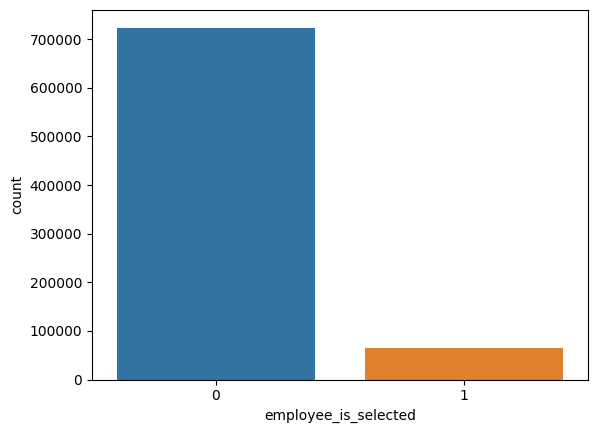

In [41]:
sns.countplot(x = 'employee_is_selected', data = df_filtered)

In [42]:
df_filtered['combined_text'] = df_filtered['current_position'] + ' ' + df_filtered['industry_sector'] + ' ' + df_filtered['n_employees'] + ' employees'
df_filtered.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_20872\1906222185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['combined_text'] = df_filtered['current_position'] + ' ' + df_filtered['industry_sector'] + ' ' + df_filtered['n_employees'] + ' employees'


lead_id  high_senority_search                current_position  \
0       53                     0                  Head of People   
1       52                     0                  SEO-specialist   
2       52                     0  Managing Partner at Hipex B.V.   
3       53                     0                CEO & Co-founder   
4       53                     0                Co-founder & COO   

   employee_is_selected n_employees industry_sector  \
0                     1          67        Internet   
1                     0          10        Internet   
2                     1          10        Internet   
3                     0          67        Internet   
4                     0          67        Internet   

                                       combined_text  
0               Head of People Internet 67 employees  
1               SEO-specialist Internet 10 employees  
2  Managing Partner at Hipex B.V. Internet 10 emp...  
3             CEO & Co-founder Internet 67 employees  
4             Co-founder & COO Internet 67 employees

In [43]:
# Clean text
def clean_text(text):
    # Use a regular expression to remove non-alphabetic characters
    cleaned_text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
    
    # Remove multiple consecutive spaces and leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())
    
    # Lower texts
    cleaned_text = cleaned_text.lower()

    return cleaned_text

df_filtered['combined_text'] = df_filtered['combined_text'].apply(lambda row: clean_text(row))

df_filtered.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_20872\3677202519.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['combined_text'] = df_filtered['combined_text'].apply(lambda row: clean_text(row))


lead_id  high_senority_search                current_position  \
0       53                     0                  Head of People   
1       52                     0                  SEO-specialist   
2       52                     0  Managing Partner at Hipex B.V.   
3       53                     0                CEO & Co-founder   
4       53                     0                Co-founder & COO   

   employee_is_selected n_employees industry_sector  \
0                     1          67        Internet   
1                     0          10        Internet   
2                     1          10        Internet   
3                     0          67        Internet   
4                     0          67        Internet   

                                       combined_text  
0               head of people internet 67 employees  
1               seo specialist internet 10 employees  
2  managing partner at hipex b v internet 10 empl...  
3               ceo co founder internet 67 employees  
4               co founder coo internet 67 employees

In [44]:
# Keep wanted columns
df_filtered = df_filtered[['lead_id', 'employee_is_selected', 'combined_text']]
df_filtered.head()

lead_id  employee_is_selected  \
0       53                     1   
1       52                     0   
2       52                     1   
3       53                     0   
4       53                     0   

                                       combined_text  
0               head of people internet 67 employees  
1               seo specialist internet 10 employees  
2  managing partner at hipex b v internet 10 empl...  
3               ceo co founder internet 67 employees  
4               co founder coo internet 67 employees

## Train, test, val split with grouping

In [45]:
# Sort data by lead_id
df_filtered = df_filtered.sort_values(by=['lead_id'])
df_filtered = df_filtered.reset_index(drop=True)

In [46]:
# Define features and target variable
X = df_filtered.drop('employee_is_selected', axis=1)
y = df_filtered['employee_is_selected']

In [47]:
group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

# Split the data while preserving groups (split total data into temp 70% and test 30%)
for temp_idx, test_idx in group_splitter.split(X, y, groups=df_filtered["lead_id"]):
    temp_data = df_filtered.iloc[temp_idx]
    test_data = df_filtered.iloc[test_idx]

X_temp = temp_data.drop('employee_is_selected', axis=1)
y_temp = temp_data['employee_is_selected']

# Split the data while preserving groups (split temp data into train 70% and val 30%)
for train_idx, val_idx in group_splitter.split(X_temp, y_temp, groups=temp_data["lead_id"]):
    train_data = temp_data.iloc[train_idx]
    val_data = temp_data.iloc[val_idx]

# Check data sizes after splitting
print(f"Train set size: {len(train_data)} ({round((len(train_data)/len(df_filtered)),1)*100})%")
print(f"Test set size: {len(test_data)} ({round((len(test_data)/len(df_filtered)),1)*100})%")
print(f"Validation set size: {len(val_data)} ({round((len(val_data)/len(df_filtered)),1)*100})%")

Train set size: 386840 (50.0)%
Test set size: 237149 (30.0)%
Validation set size: 165340 (20.0)%


In [48]:
# Reset indexes of df's
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

# Define X's and y's
X_train = train_data['combined_text']
y_train = train_data['employee_is_selected']

X_test = test_data['combined_text']
y_test = test_data['employee_is_selected']

X_val = val_data['combined_text']
y_val = val_data['employee_is_selected']

# LightGBM

## Data preprocessing

In [49]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)

# Store vectorizer
with open('models/lgbm_model_1/vectorizer.pkl', 'wb') as model_file:
    pickle.dump(vectorizer, model_file)

In [50]:
# Query data
train_query_data = train_data.groupby('lead_id').size().values
val_query_data = val_data.groupby('lead_id').size().values

## LGBM Model 1

First LGBMRanker model.

### Model training

In [103]:
lgbm_model_1 = lgbm.LGBMRanker(
    objective="lambdarank",
    boosting_type= "gbdt",
    metric="ndcg",
    learning_rate=0.1,
    random_state=42
)

# Train the LambdaMART model
lgbm_model_1 = lgbm_model_1.fit(
    X=X_train_tfidf,
    y=y_train,
    group=train_query_data,
    eval_set=[(X_val_tfidf, y_val)],
    eval_group=[val_query_data],
    eval_metric="ndcg"
)

# Save the trained model to a file
with open('models/lgbm_model_1/lgbm_model_1.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model_1, model_file)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.192992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


### Model testing

In [135]:
# Open model from file
with open('models/lgbm_model_1/lgbm_model_1.pkl', 'rb') as model_file:
    lgbm_model_1 = pickle.load(model_file)

In [96]:
# Predict test set
test_pred = lgbm_model_1.predict(X_test_tfidf)
test_query_data = test_data.groupby('lead_id').size().values

In [97]:
# Compute NDCG score
ndcg = ndcg_score([y_test], [test_pred]) # Only consider top 3 ranks in ndcg score calculation
print(f'NDCG Score on Test Data: {ndcg:.4f}')

NDCG Score on Test Data: 0.8685


In [118]:
# Function to properly test a model on the test set by calculating score per group
def test_model(ranker, k=10):
    # Create empty lists to store predictions and true labels for each query group (lead id groups)
    all_predictions = []
    all_true_labels = []
    query_group_ids = test_data['lead_id']

    # Iterate over query groups (in this case lead ids)
    lead_ids = np.unique(query_group_ids)
    for lead_id in lead_ids:
        
        # Filter the data for the specific lead_id
        single_lead_data = test_data[test_data['lead_id'] == lead_id].copy()

        # Preprocess the text features for the single lead
        single_lead_tfidf = vectorizer.transform(single_lead_data['combined_text'])

        # Predict single lead scores
        single_lead_pred = ranker.predict(single_lead_tfidf)
        
        # Store predictions
        all_predictions.extend(single_lead_pred)
        all_true_labels.extend(single_lead_data['employee_is_selected'])

    # Calculate NDCG for all predictions and true labels
    ndcg = ndcg_score([all_true_labels], [all_predictions], k=k)

    return ndcg

In [136]:
# Print the overall NDCG score
print("Overall NDCG:", test_model(lgbm_model_1, k=3))

Overall NDCG: 0.6517760083649397


## LGBM Model 2

This model incorporates a first attempt at tuning the hyperparameters.

### Model training

In [137]:
def objective(trial):
    # Define the search space for hyperparameters
    # The objective 'lambdarank' and boosting type 'gbdt' combined result in a LambdaMART model.
    params = {
        'random_state': 42,
        'objective': 'lambdarank',
        'boosting_type': 'gbdt',
        'metric': 'ndcg',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.101, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 25, 50, step=1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2600, step=500),
        'max_depth': trial.suggest_int('max_depth', -1, 500, step=50),
    }
    
    lgbm_model = lgbm.LGBMRanker(
        **params
    )

    # Train the LambdaMART model
    lgbm_model = lgbm_model.fit(
        X=X_train_tfidf,
        y=y_train,
        group=train_query_data,
        eval_set=[(X_val_tfidf, y_val)],
        eval_group=[val_query_data],
        eval_metric="ndcg"
    )

    # Evaluate the model using NDCG score on the test set
    ndcg = test_model(lgbm_model, k=10)

    return ndcg

In [139]:
study = optuna.create_study(direction='maximize')  # Maximize NDCG
study.optimize(objective, n_trials=15)

# Store the best hyperparameters and NDCG score
best_params = study.best_params
best_ndcg = study.best_value

# Create and fit lgbm model with best params
lgbm_model_2 = lgbm.LGBMRanker(
        **best_params
    )
lgbm_model_2 = lgbm_model_2.fit(
        X=X_train_tfidf,
        y=y_train,
        group=train_query_data,
        eval_set=[(X_val_tfidf, y_val)],
        eval_group=[val_query_data],
        eval_at=10
    )

# Save the trained model to a file
with open('models/lgbm_model_2/lgbm_model_2.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model_2, model_file)

# Print the best hyperparameters and NDCG score
print(f"Best Hyperparameters: {best_params}")
print(f"Best NDCG Score: {best_ndcg}")

[I 2023-10-12 15:07:53,705] A new study created in memory with name: no-name-04374e6f-e818-4c00-af5f-63a349913e08
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.614065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn'

[I 2023-10-12 15:10:13,095] Trial 0 finished with value: 0.2960609480409601 and parameters: {'learning_rate': 0.091, 'num_leaves': 31, 'n_estimators': 600, 'max_depth': 399}. Best is trial 0 with value: 0.2960609480409601.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.284091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:13:21,949] Trial 1 finished with value: 0.08610991699661572 and parameters: {'learning_rate': 0.011, 'num_leaves': 40, 'n_estimators': 1100, 'max_depth': 299}. Best is trial 0 with value: 0.2960609480409601.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.987460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:16:31,991] Trial 2 finished with value: 0.2200917662980802 and parameters: {'learning_rate': 0.081, 'num_leaves': 25, 'n_estimators': 1600, 'max_depth': 49}. Best is trial 0 with value: 0.2960609480409601.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.457970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:20:16,605] Trial 3 finished with value: 0.47172734314484893 and parameters: {'learning_rate': 0.001, 'num_leaves': 38, 'n_estimators': 1100, 'max_depth': 299}. Best is trial 3 with value: 0.47172734314484893.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.591539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:21:34,205] Trial 4 finished with value: 0.47473784556720694 and parameters: {'learning_rate': 0.031, 'num_leaves': 32, 'n_estimators': 100, 'max_depth': 499}. Best is trial 4 with value: 0.47473784556720694.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.600553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:24:15,412] Trial 5 finished with value: 0.2732311716370021 and parameters: {'learning_rate': 0.101, 'num_leaves': 50, 'n_estimators': 1100, 'max_depth': 449}. Best is trial 4 with value: 0.47473784556720694.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.943704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:26:14,411] Trial 6 finished with value: 0.14201905717762706 and parameters: {'learning_rate': 0.091, 'num_leaves': 32, 'n_estimators': 600, 'max_depth': 299}. Best is trial 4 with value: 0.47473784556720694.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.090298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:30:19,702] Trial 7 finished with value: 0.16815228646891087 and parameters: {'learning_rate': 0.021, 'num_leaves': 29, 'n_estimators': 2100, 'max_depth': 249}. Best is trial 4 with value: 0.47473784556720694.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.111018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:34:45,167] Trial 8 finished with value: 0.38431135260440824 and parameters: {'learning_rate': 0.021, 'num_leaves': 47, 'n_estimators': 2100, 'max_depth': 249}. Best is trial 4 with value: 0.47473784556720694.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.718560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:36:51,622] Trial 9 finished with value: 0.18081539273797081 and parameters: {'learning_rate': 0.07100000000000001, 'num_leaves': 37, 'n_estimators': 600, 'max_depth': -1}. Best is trial 4 with value: 0.47473784556720694.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.003945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:38:19,953] Trial 10 finished with value: 0.8 and parameters: {'learning_rate': 0.051000000000000004, 'num_leaves': 43, 'n_estimators': 100, 'max_depth': 499}. Best is trial 10 with value: 0.8.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.546850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:39:42,185] Trial 11 finished with value: 0.8 and parameters: {'learning_rate': 0.051000000000000004, 'num_leaves': 43, 'n_estimators': 100, 'max_depth': 499}. Best is trial 10 with value: 0.8.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.675484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:41:02,037] Trial 12 finished with value: 0.8 and parameters: {'learning_rate': 0.051000000000000004, 'num_leaves': 44, 'n_estimators': 100, 'max_depth': 499}. Best is trial 10 with value: 0.8.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.445978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:42:19,438] Trial 13 finished with value: 0.8 and parameters: {'learning_rate': 0.051000000000000004, 'num_leaves': 43, 'n_estimators': 100, 'max_depth': 399}. Best is trial 10 with value: 0.8.
c:\Users\PC\anaconda3\envs\env2\Lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [-1, 500] and step=50, but the range is not divisible by `step`. It will be replaced by [-1, 499].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.501253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169942
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4418


[I 2023-10-12 15:46:38,085] Trial 14 finished with value: 0.17498338897571042 and parameters: {'learning_rate': 0.061, 'num_leaves': 43, 'n_estimators': 2600, 'max_depth': 399}. Best is trial 10 with value: 0.8.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.104486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457
Best Hyperparameters: {'learning_rate': 0.051000000000000004, 'num_leaves': 43, 'n_estimators': 100, 'max_depth': 499}
Best NDCG Score: 0.8


### Model testing

In [140]:
# Open model from file
with open('models/lgbm_model_2/lgbm_model_2.pkl', 'rb') as model_file:
    lgbm_model_2 = pickle.load(model_file)

In [143]:
# Compute NDCG score
test_model(lgbm_model_2, k=3)

0.2

## LGBM Model 3

Add unbalanced data flag to parameter tuning and set testing k (in NDCG@k) to 3 to prioritize the top 3 ranking when scoring the model performance.

#### Model training

In [125]:
def objective(trial):
    # Define the search space for hyperparameters
    # The objective 'lambdarank' and boosting type 'gbdt' combined result in a LambdaMART model.
    params = {
        'objective': 'lambdarank',
        'boosting_type': 'gbdt',
        'metric': 'ndcg',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.101, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 25, 50, step=1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', -1, 319, step=20),
        'is_unbalance': True
    }
    
    lgbm_model = lgbm.LGBMRanker(
        **params
    )

    # Train the LambdaMART model
    lgbm_model = lgbm_model.fit(
        X=X_train_tfidf,
        y=y_train,
        group=train_query_data,
        eval_set=[(X_val_tfidf, y_val)],
        eval_group=[val_query_data]
    )

    # Evaluate the model using NDCG score on the test set
    ndcg = test_model(lgbm_model, k=3)

    return ndcg

In [126]:
study = optuna.create_study(direction='maximize')  # Maximize NDCG
study.optimize(objective, n_trials=20)

# Store the best hyperparameters and NDCG score
best_params = study.best_params
best_ndcg = study.best_value

# Create and fit lgbm model with best params
lgbm_model_3 = lgbm.LGBMRanker(
        **best_params
    )
lgbm_model_3 = lgbm_model_3.fit(
        X=X_train_tfidf,
        y=y_train,
        group=train_query_data,
        eval_set=[(X_val_tfidf, y_val)],
        eval_group=[val_query_data],
        eval_metric='ndcg'
    )

# Save the trained model to a file
with open('models/lgbm_model_3/lgbm_model_3.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model_3, model_file)

# Print the best hyperparameters and NDCG score
print(f"Best Hyperparameters: {best_params}")
print(f"Best NDCG Score: {best_ndcg}")

[I 2023-10-11 11:23:30,746] A new study created in memory with name: no-name-02a70ee4-bb59-4f81-a44a-5e7c08bf1467


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.145395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:25:50,433] Trial 0 finished with value: 0.4569748797434527 and parameters: {'learning_rate': 0.001, 'num_leaves': 46, 'n_estimators': 400, 'max_depth': 79}. Best is trial 0 with value: 0.4569748797434527.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.664564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:27:48,680] Trial 1 finished with value: 0.4569748797434527 and parameters: {'learning_rate': 0.001, 'num_leaves': 27, 'n_estimators': 200, 'max_depth': 39}. Best is trial 0 with value: 0.4569748797434527.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.388954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leav

[I 2023-10-11 11:29:57,644] Trial 2 finished with value: 0.48144531250000006 and parameters: {'learning_rate': 0.061, 'num_leaves': 31, 'n_estimators': 100, 'max_depth': 59}. Best is trial 2 with value: 0.48144531250000006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.564872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:32:10,093] Trial 3 finished with value: 0.7877114904091026 and parameters: {'learning_rate': 0.021, 'num_leaves': 28, 'n_estimators': 400, 'max_depth': 39}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.728109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:34:10,765] Trial 4 finished with value: 0.47169811320754723 and parameters: {'learning_rate': 0.021, 'num_leaves': 36, 'n_estimators': 100, 'max_depth': 259}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.976152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:35:43,450] Trial 5 finished with value: 0.05865984075284457 and parameters: {'learning_rate': 0.081, 'num_leaves': 33, 'n_estimators': 200, 'max_depth': 159}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.209392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:37:24,201] Trial 6 finished with value: 0.2960819109658652 and parameters: {'learning_rate': 0.101, 'num_leaves': 39, 'n_estimators': 300, 'max_depth': 99}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.752923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:39:17,594] Trial 7 finished with value: 0.5307212739772434 and parameters: {'learning_rate': 0.051000000000000004, 'num_leaves': 38, 'n_estimators': 300, 'max_depth': 299}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.217295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:40:40,073] Trial 8 finished with value: 0.4742857142857143 and parameters: {'learning_rate': 0.031, 'num_leaves': 36, 'n_estimators': 100, 'max_depth': 179}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.367186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:42:36,140] Trial 9 finished with value: 0.7039180890341348 and parameters: {'learning_rate': 0.041, 'num_leaves': 29, 'n_estimators': 300, 'max_depth': 79}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.308894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:44:40,897] Trial 10 finished with value: 0.2653606369886217 and parameters: {'learning_rate': 0.021, 'num_leaves': 25, 'n_estimators': 500, 'max_depth': -1}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.871498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:46:33,035] Trial 11 finished with value: 0.23463936301137828 and parameters: {'learning_rate': 0.041, 'num_leaves': 30, 'n_estimators': 400, 'max_depth': 159}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.305011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:48:28,034] Trial 12 finished with value: 0.0 and parameters: {'learning_rate': 0.07100000000000001, 'num_leaves': 44, 'n_estimators': 400, 'max_depth': -1}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.741510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:50:27,987] Trial 13 finished with value: 0.4127832130934116 and parameters: {'learning_rate': 0.021, 'num_leaves': 27, 'n_estimators': 500, 'max_depth': 119}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.570776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:52:15,483] Trial 14 finished with value: 0.2960819109658652 and parameters: {'learning_rate': 0.041, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 39}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.446687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:54:21,926] Trial 15 finished with value: 0.4764649375600384 and parameters: {'learning_rate': 0.011, 'num_leaves': 30, 'n_estimators': 400, 'max_depth': 219}. Best is trial 3 with value: 0.7877114904091026.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.643276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:56:07,652] Trial 16 finished with value: 0.9478579193308048 and parameters: {'learning_rate': 0.041, 'num_leaves': 33, 'n_estimators': 200, 'max_depth': 99}. Best is trial 16 with value: 0.9478579193308048.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.318211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:57:44,775] Trial 17 finished with value: 0.7988805459902472 and parameters: {'learning_rate': 0.061, 'num_leaves': 33, 'n_estimators': 200, 'max_depth': 119}. Best is trial 16 with value: 0.9478579193308048.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.197009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 11:59:13,875] Trial 18 finished with value: 0.2960819109658652 and parameters: {'learning_rate': 0.081, 'num_leaves': 34, 'n_estimators': 200, 'max_depth': 119}. Best is trial 16 with value: 0.9478579193308048.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.269240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457


[I 2023-10-11 12:00:54,635] Trial 19 finished with value: 0.17690709132574783 and parameters: {'learning_rate': 0.061, 'num_leaves': 40, 'n_estimators': 200, 'max_depth': 199}. Best is trial 16 with value: 0.9478579193308048.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.043689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170050
[LightGBM] [Info] Number of data points in the train set: 386840, number of used features: 4457
Best Hyperparameters: {'learning_rate': 0.041, 'num_leaves': 33, 'n_estimators': 200, 'max_depth': 99}
Best NDCG Score: 0.9478579193308048


### Model testing

In [144]:
# Open model from file
with open('models/lgbm_model_3/lgbm_model_3.pkl', 'rb') as model_file:
    lgbm_model_3 = pickle.load(model_file)

In [145]:
# Compute NDCG score
test_model(lgbm_model_3, k=3)

0.9478579193308048

## Testing single lead

In [127]:
def rank_single_lead(lead_id, ranker):
    # Filter the data for the specific lead_id
    single_lead_data = test_data[test_data['lead_id'] == lead_id].copy()
    k = len(single_lead_data)

    # Preprocess the text features for the single lead
    single_lead_tfidf = vectorizer.transform(single_lead_data['combined_text'])

    # Predict single lead
    single_lead_pred = ranker.predict(single_lead_tfidf)
    single_lead_data['predicted_score'] = single_lead_pred

    # Scale predicted score
    min_value = single_lead_data['predicted_score'].min()
    max_value = single_lead_data['predicted_score'].max()
    single_lead_data['scaled_predicted_score'] = (single_lead_data['predicted_score'] - min_value) / (max_value - min_value)
    single_lead_data = single_lead_data.sort_values(by='scaled_predicted_score', ascending=False)

    # Compute NDCG score
    ndcg = ndcg_score(y_true=[single_lead_data['employee_is_selected']], y_score=[single_lead_pred], k=k)

    # Print data and overall ndcg score
    print(f'NDCG Score on Test Data: {ndcg:.4f}')
    display(single_lead_data)

In [128]:
rank_single_lead(374, lgbm_model_3)

NDCG Score on Test Data: 0.4416


lead_id  employee_is_selected  \
609      374                     0   
611      374                     0   
618      374                     0   
624      374                     0   
610      374                     0   
613      374                     0   
612      374                     1   
629      374                     0   
619      374                     1   
608      374                     0   
631      374                     0   
623      374                     0   
625      374                     0   
627      374                     0   
620      374                     0   
615      374                     0   
616      374                     0   
614      374                     0   
630      374                     0   
617      374                     0   
607      374                     0   
605      374                     0   
632      374                     0   
633      374                     0   
626      374                     0   
622      374                     0   
621      374                     0   
604      374                     0   
606      374                     0   
628      374                     0   

                                         combined_text  predicted_score  \
609  global human resources director ranching 564 e...         0.899800   
611  ceo and chairman of the executive board ranchi...         0.276869   
618  hoofd hr en salarisadministratie interim ranch...         0.239518   
624           managing director ranching 564 employees         0.123154   
610     chief financial officer ranching 564 employees        -0.361952   
613  managing director bu nederland vlaanderen ranc...        -0.475087   
612  head of it instructure services ranching 564 e...        -0.923919   
629    productmarketing manager ranching 564 employees        -0.939946   
619  head of development information services ranch...        -1.059956   
608  owner jeeigensite nl principal developer ranch...        -1.074296   
631  head global product management sales developme...        -1.108741   
623    global director genetics ranching 564 employees        -1.157977   
625    head genetic development ranching 564 employees        -1.197061   
627                  area hoofd ranching 564 employees        -1.636736   
620                  area hoofd ranching 564 employees        -1.636736   
615                  area hoofd ranching 564 employees        -1.636736   
616  product owner chapter lead ux ranching 564 emp...        -1.647523   
614  head animal evaluation unit ranching 564 emplo...        -1.669174   
630         key account manager ranching 564 employees        -1.841502   
617                  voorzitter ranching 564 employees        -2.011349   
607     voorzitter jongerenraad ranching 564 employees        -2.011349   
605                 bestuurslid ranching 564 employees        -2.059864   
632       uitvoerend bestuurder ranching 564 employees        -2.061877   
633          key accountmanager ranching 564 employees        -2.061877   
626                 boardmember ranching 564 employees        -2.061877   
622  voorzitter commissie bijzondere diensten ranch...        -2.061877   
621  vicevoorzitter districtsraad district centraal...        -2.061877   
604  senior consultant to the executive board ranch...        -2.184624   
606              lid adviesraad ranching 564 employees        -2.415866   
628  infrastructuur engineer zzp ranching 564 emplo...        -2.539173   

     scaled_predicted_score  
609                1.000000  
611                0.818861  
618                0.808000  
624                0.774163  
610                0.633102  
613                0.600204  
612                0.469691  
629                0.465030  
619                0.430133  
608                0.425964  
631                0.415947  
623                0.401630  
625                0.390265  
627                0.262415  
620                0.262415  
615                0